# CERN Liquid Hydrogen Bubble Chamber

Example to simulate the CERN 30cm bubble chamber fill with liquid hydrogen and using a pion beam of 330 MeV from PS. The original device was like this:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/30_cm_bubble_chamber.jpg/447px-30_cm_bubble_chamber.jpg)


In [1]:
using Geant4
using Geant4.SystemOfUnits
using Printf, GeometryBasics
using CairoMakie, Rotations, IGLWrap_jll  # to force loading G4Vis extension

## Define the detector chamber 

In [2]:
include("DetectorHBC30.jl")
hbc30 = HBC30()

HBC30(300.0, 50.0, false, 192.50000000000003)

## Define the simulation data
The data structure `HBC30SimData` will be filled by the user actions at the correct moment during the simulation. We collect the points for each track at the step bounderies together with the initial kinetic energy and particle name and charge.

In [3]:
#---Define Simulation Data struct------------------------------------------------------------------
struct Track
    particle::String
    charge::Int
    energy::Float64
    points::Vector{Point3{Float64}}
end
mutable struct HBC30SimData <: G4JLSimulationData
    #---Run data-----------------------------------------------------------------------------------
    fParticle::String
    fEkin::Float64
    #---trigger/veto-------------------------------------------------------------------------------
    veto::Bool
    #---tracks-------------------------------------------------------------------------------------
    tracks::Vector{Track}
    HBC30SimData() = new("", 0.0, false, [])
end


## Define the needed user actions
- **beginrun** stores the particle type and initial kinetic energy of the generated primary particle
- **beginevent** clear the trigger `veto` and the list of tracks for the current event
- **pretrackaction** pushes a new `Track` with the particle name, charge, intial energy and initial point
- **posttackactkion** is used exclusevily to set the `veto` if the initial particle exists the world without a sizeable interaction
- **stepaction** pushes points to the latest `Track` in the track list


In [4]:
#---Step action------------------------------------------------------------------------------------
function stepaction(step::G4Step, app::G4JLApplication)::Nothing
    tracks = getSIMdata(app).tracks
    p = step |> GetPostStepPoint |> GetPosition
    auxpoints = step |> GetPointerToVectorOfAuxiliaryPoints
    if auxpoints != C_NULL
        for ap in auxpoints
            push!(tracks[end].points, Point3{Float64}(x(ap),y(ap),z(ap)))
        end
    end
    push!(tracks[end].points, Point3{Float64}(x(p),y(p),z(p)))
    return
end
#---Tracking pre-action---------------------------------------------------------------------------- 
function pretrackaction(track::G4Track, app::G4JLApplication)::Nothing
    tracks = getSIMdata(app).tracks
    p = GetPosition(track)[]
    particle = track |> GetParticleDefinition
    name = particle |> GetParticleName |> String
    charge = particle |> GetPDGCharge |> Int
    energy = track |> GetKineticEnergy
    push!(tracks, Track(name, charge, energy, [Point3{Float64}(x(p),y(p),z(p))]))
    return
end
#---Tracking post-action---------------------------------------------------------------------------- 
function posttrackaction(track::G4Track, app::G4JLApplication)::Nothing
    data = getSIMdata(app)
    id = track |> GetTrackID
    energy = track |> GetKineticEnergy
    if id == 1 && energy > 0.80 * data.fEkin # primary particle did not losse any energy
        if track |> GetStep |> GetPostStepPoint |> GetPhysicalVolume == C_NULL  # Only if outside world
            data.veto = true
        end
    end
    return
end
#---Begin-event-action---------------------------------------------------------------------------- 
function beginevent(::G4Event, app::G4JLApplication)::Nothing
    data = getSIMdata(app)
    data.veto = false
    empty!(data.tracks)
    return
end
#---Begin Run Action-------------------------------------------------------------------------------
function beginrun(run::G4Run, app::G4JLApplication)::Nothing
    data = getSIMdata(app)
    gun = app.generator.data.gun
    data.fParticle = gun |> GetParticleDefinition |> GetParticleName |> String
    data.fEkin = gun |> GetParticleEnergy
    return
end

beginrun (generic function with 1 method)

## Define the primary particle generator, the magnetic filed and the application

In [5]:
import Geant4.SystemOfUnits:tesla
#--------------------------------------------------------------------------------------------------
#---Particle Gun initialization--------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
particlegun = G4JLGunGenerator(particle = "pi+", 
                               energy = 330MeV, 
                               direction = G4ThreeVector(0,-1,0), 
                               position = G4ThreeVector(0, hbc30.worldZHalfLength,0))

#--------------------------------------------------------------------------------------------------
#---Magnetic Field initialization------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
bfield = G4JLUniformMagField(G4ThreeVector(0,0, 1.5tesla))

#--------------------------------------------------------------------------------------------------
#---Create the Application-------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
app = G4JLApplication(; detector = hbc30,                             # detector with parameters
                        simdata = HBC30SimData(),                     # simulation data structure
                        generator = particlegun,                      # primary particle generator
                        field = bfield,                               # uniform magnetic field
                        nthreads = 0,                                 # # of threads (0 = no MT)
                        physics_type = FTFP_BERT,                     # what physics list to instantiate
                        stepaction_method = stepaction,               # step action method
                        begineventaction_method = beginevent,         # begin-event action (initialize per-event data)
                        pretrackaction_method = pretrackaction,       # pre-tracking action
                        posttrackaction_method = posttrackaction,     # post-tracking action
                        beginrunaction_method = beginrun              # begin run action
                      );


**************************************************************
 Geant4 version Name: geant4-11-02 [MT]   (8-December-2023)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************



## Draw and trigger functions

In [6]:
#---Draw functions---------------------------------------------------------------------------------
function drawdetector(s, app)
    world = GetWorldVolume()
    Geant4.draw!(s, world)
end

function drawevent(s, app)
    data = app.simdata[1]
    # clear previous plots from previous event
    tobe = [p for p in plots(s) if p isa Lines || p isa Makie.Text]  # The event is made of lines and text 
    for p in tobe
        delete!(s,p)
    end
    # draw new event
    for t in data.tracks
        style = abs(t.charge) > 0. ? :solid : :dot
        lines!(s, t.points, linestyle=style)
        if t.energy > data.fEkin/20
            text!(s, t.points[end], text=t.particle)
        end
    end
end

#---Very simplistic trigger to get interesting events to plot--------------------------------------
function nexttrigger(app)
    data = app.simdata[1]
    beamOn(app,1)
    n = 1
    while data.veto
        beamOn(app,1)
        n += 1
    end
    println("Got a trigger after $n generated particles")
end

nexttrigger (generic function with 1 method)

In [7]:
#---Configure, Initialize and Run------------------------------------------------------------------                      
configure(app)
initialize(app)

ui`/tracking/storeTrajectory 2` # store auxiliary points to smooth trajectory

 G4ChordFinder: stepperDriverId: 2


0

Got a trigger after 42 generated particles


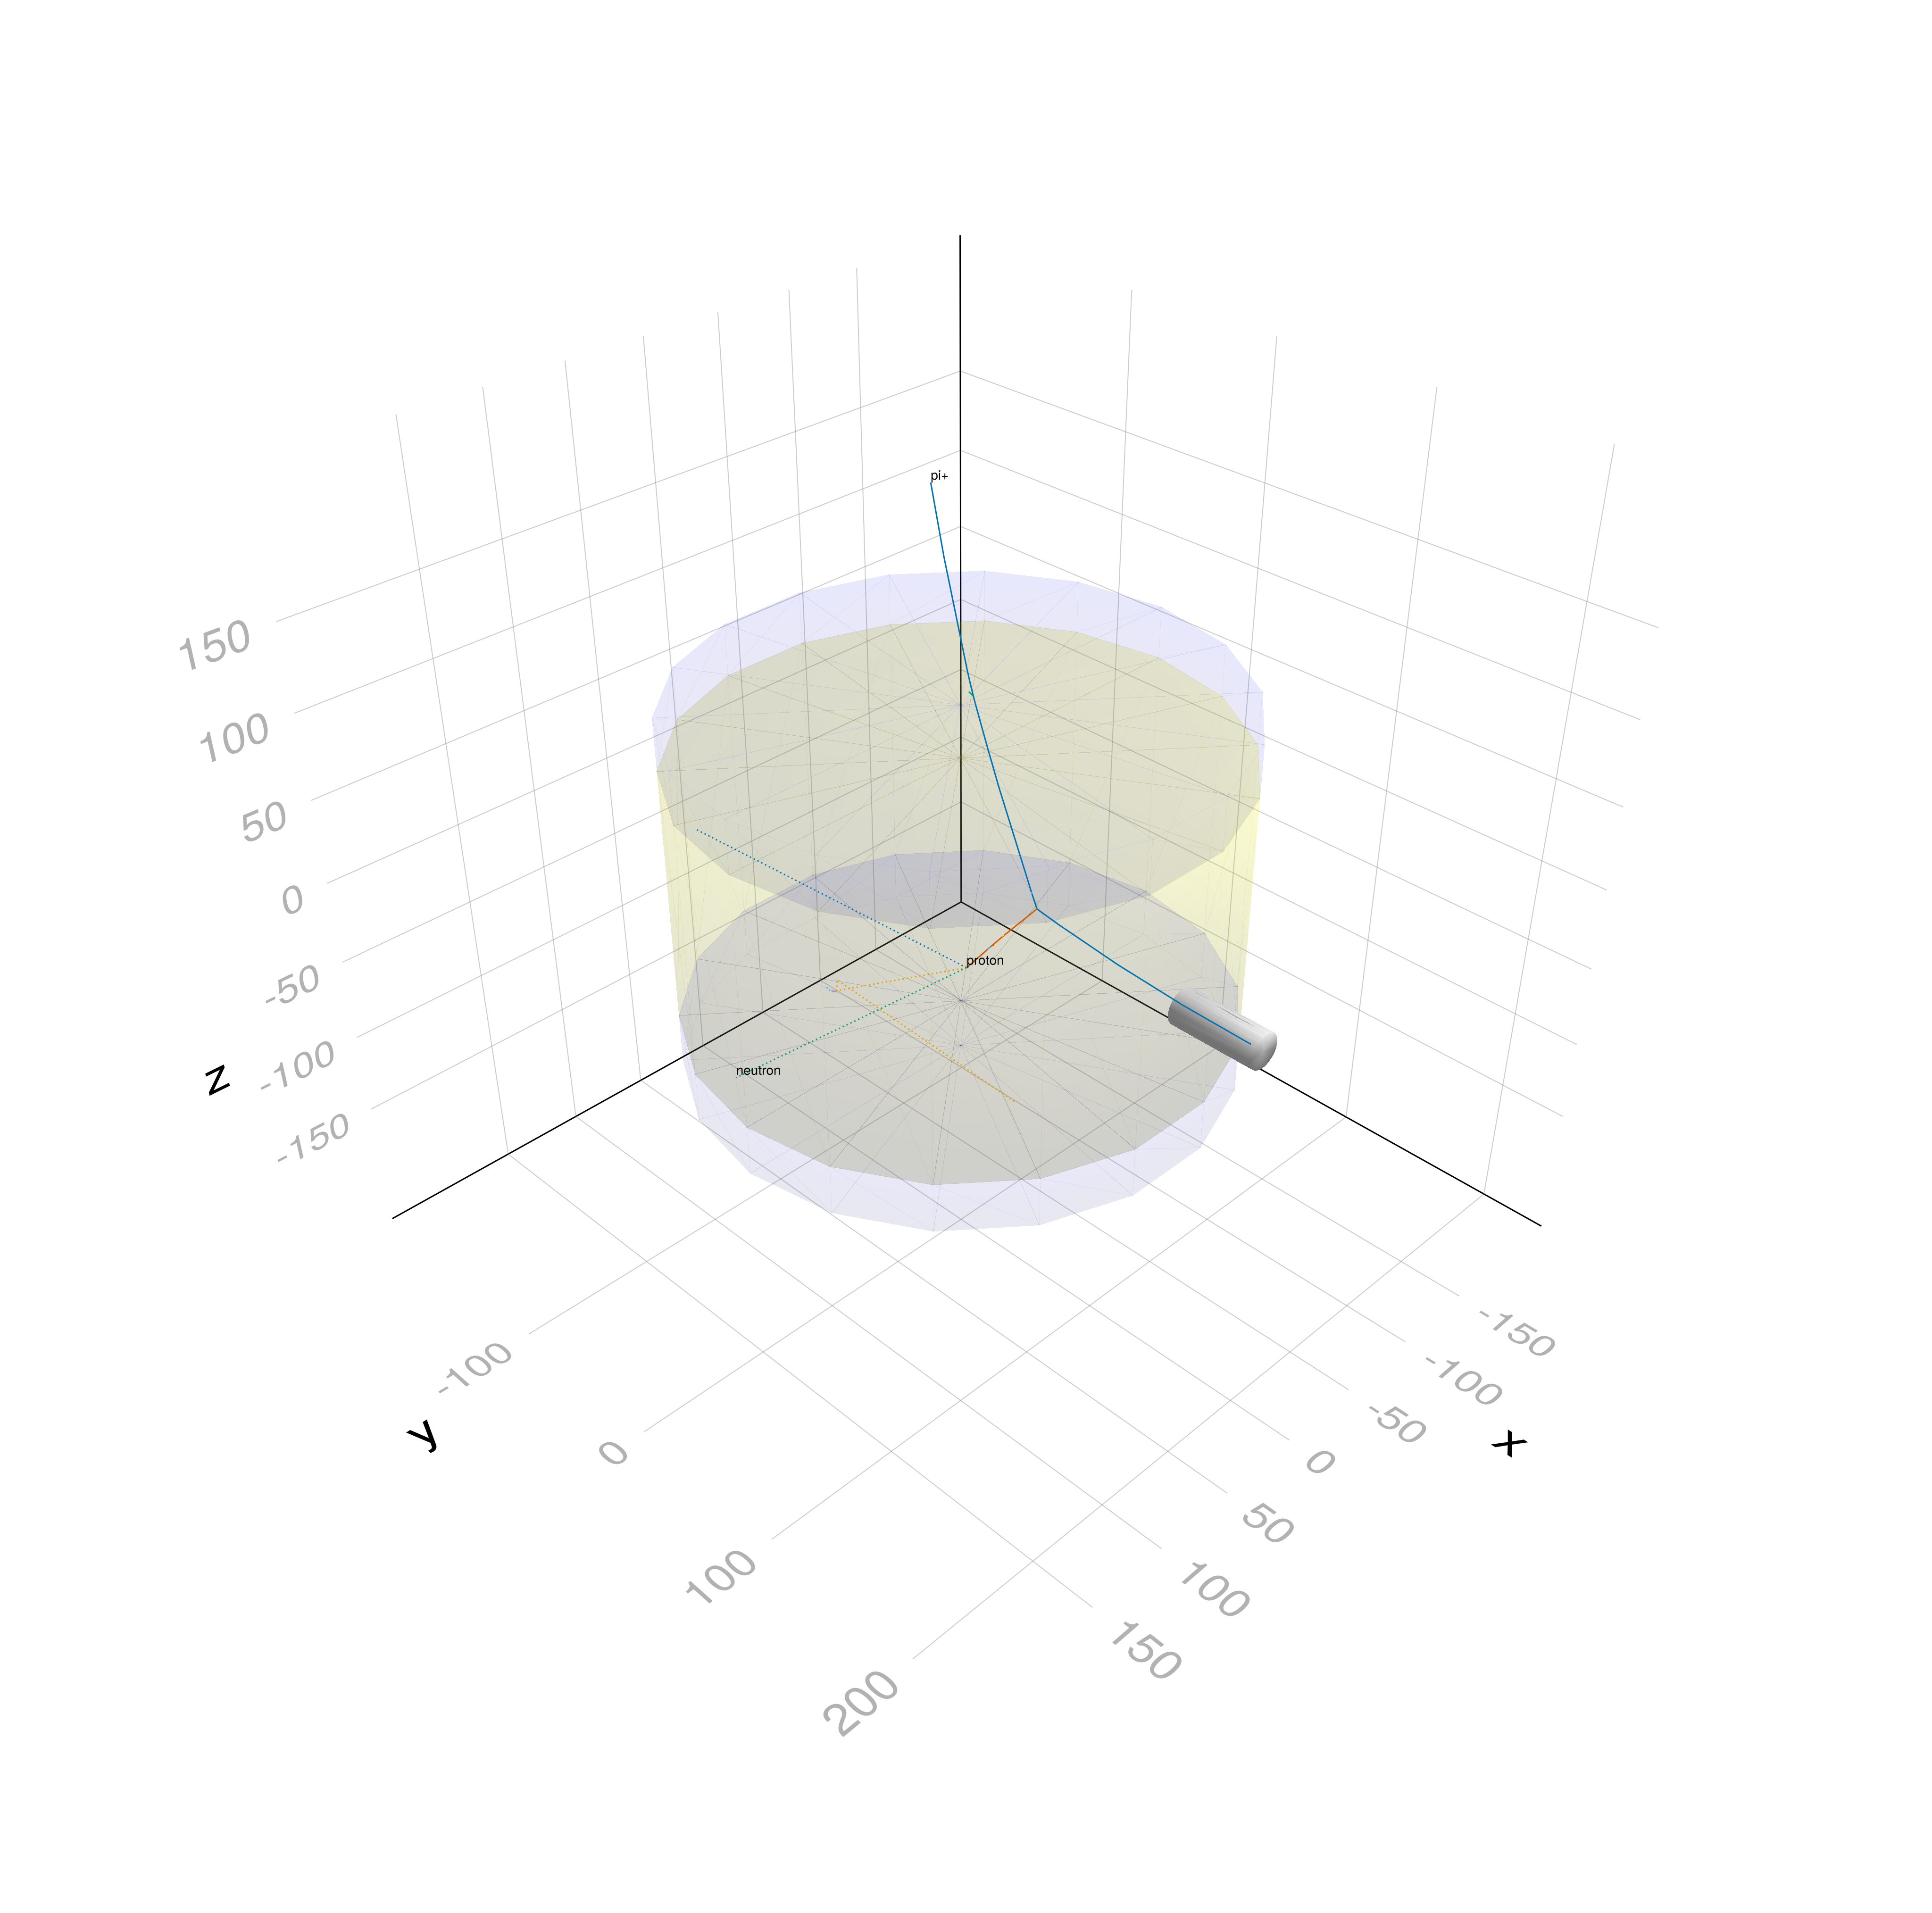

In [8]:
#---Draw detector and first event that triggers
fig = Figure(size=(2048,2028))
s = LScene(fig[1,1])

drawdetector(s, app)
nexttrigger(app); drawevent(s, app)

display("image/png", fig)

Got a trigger after 9 generated particles


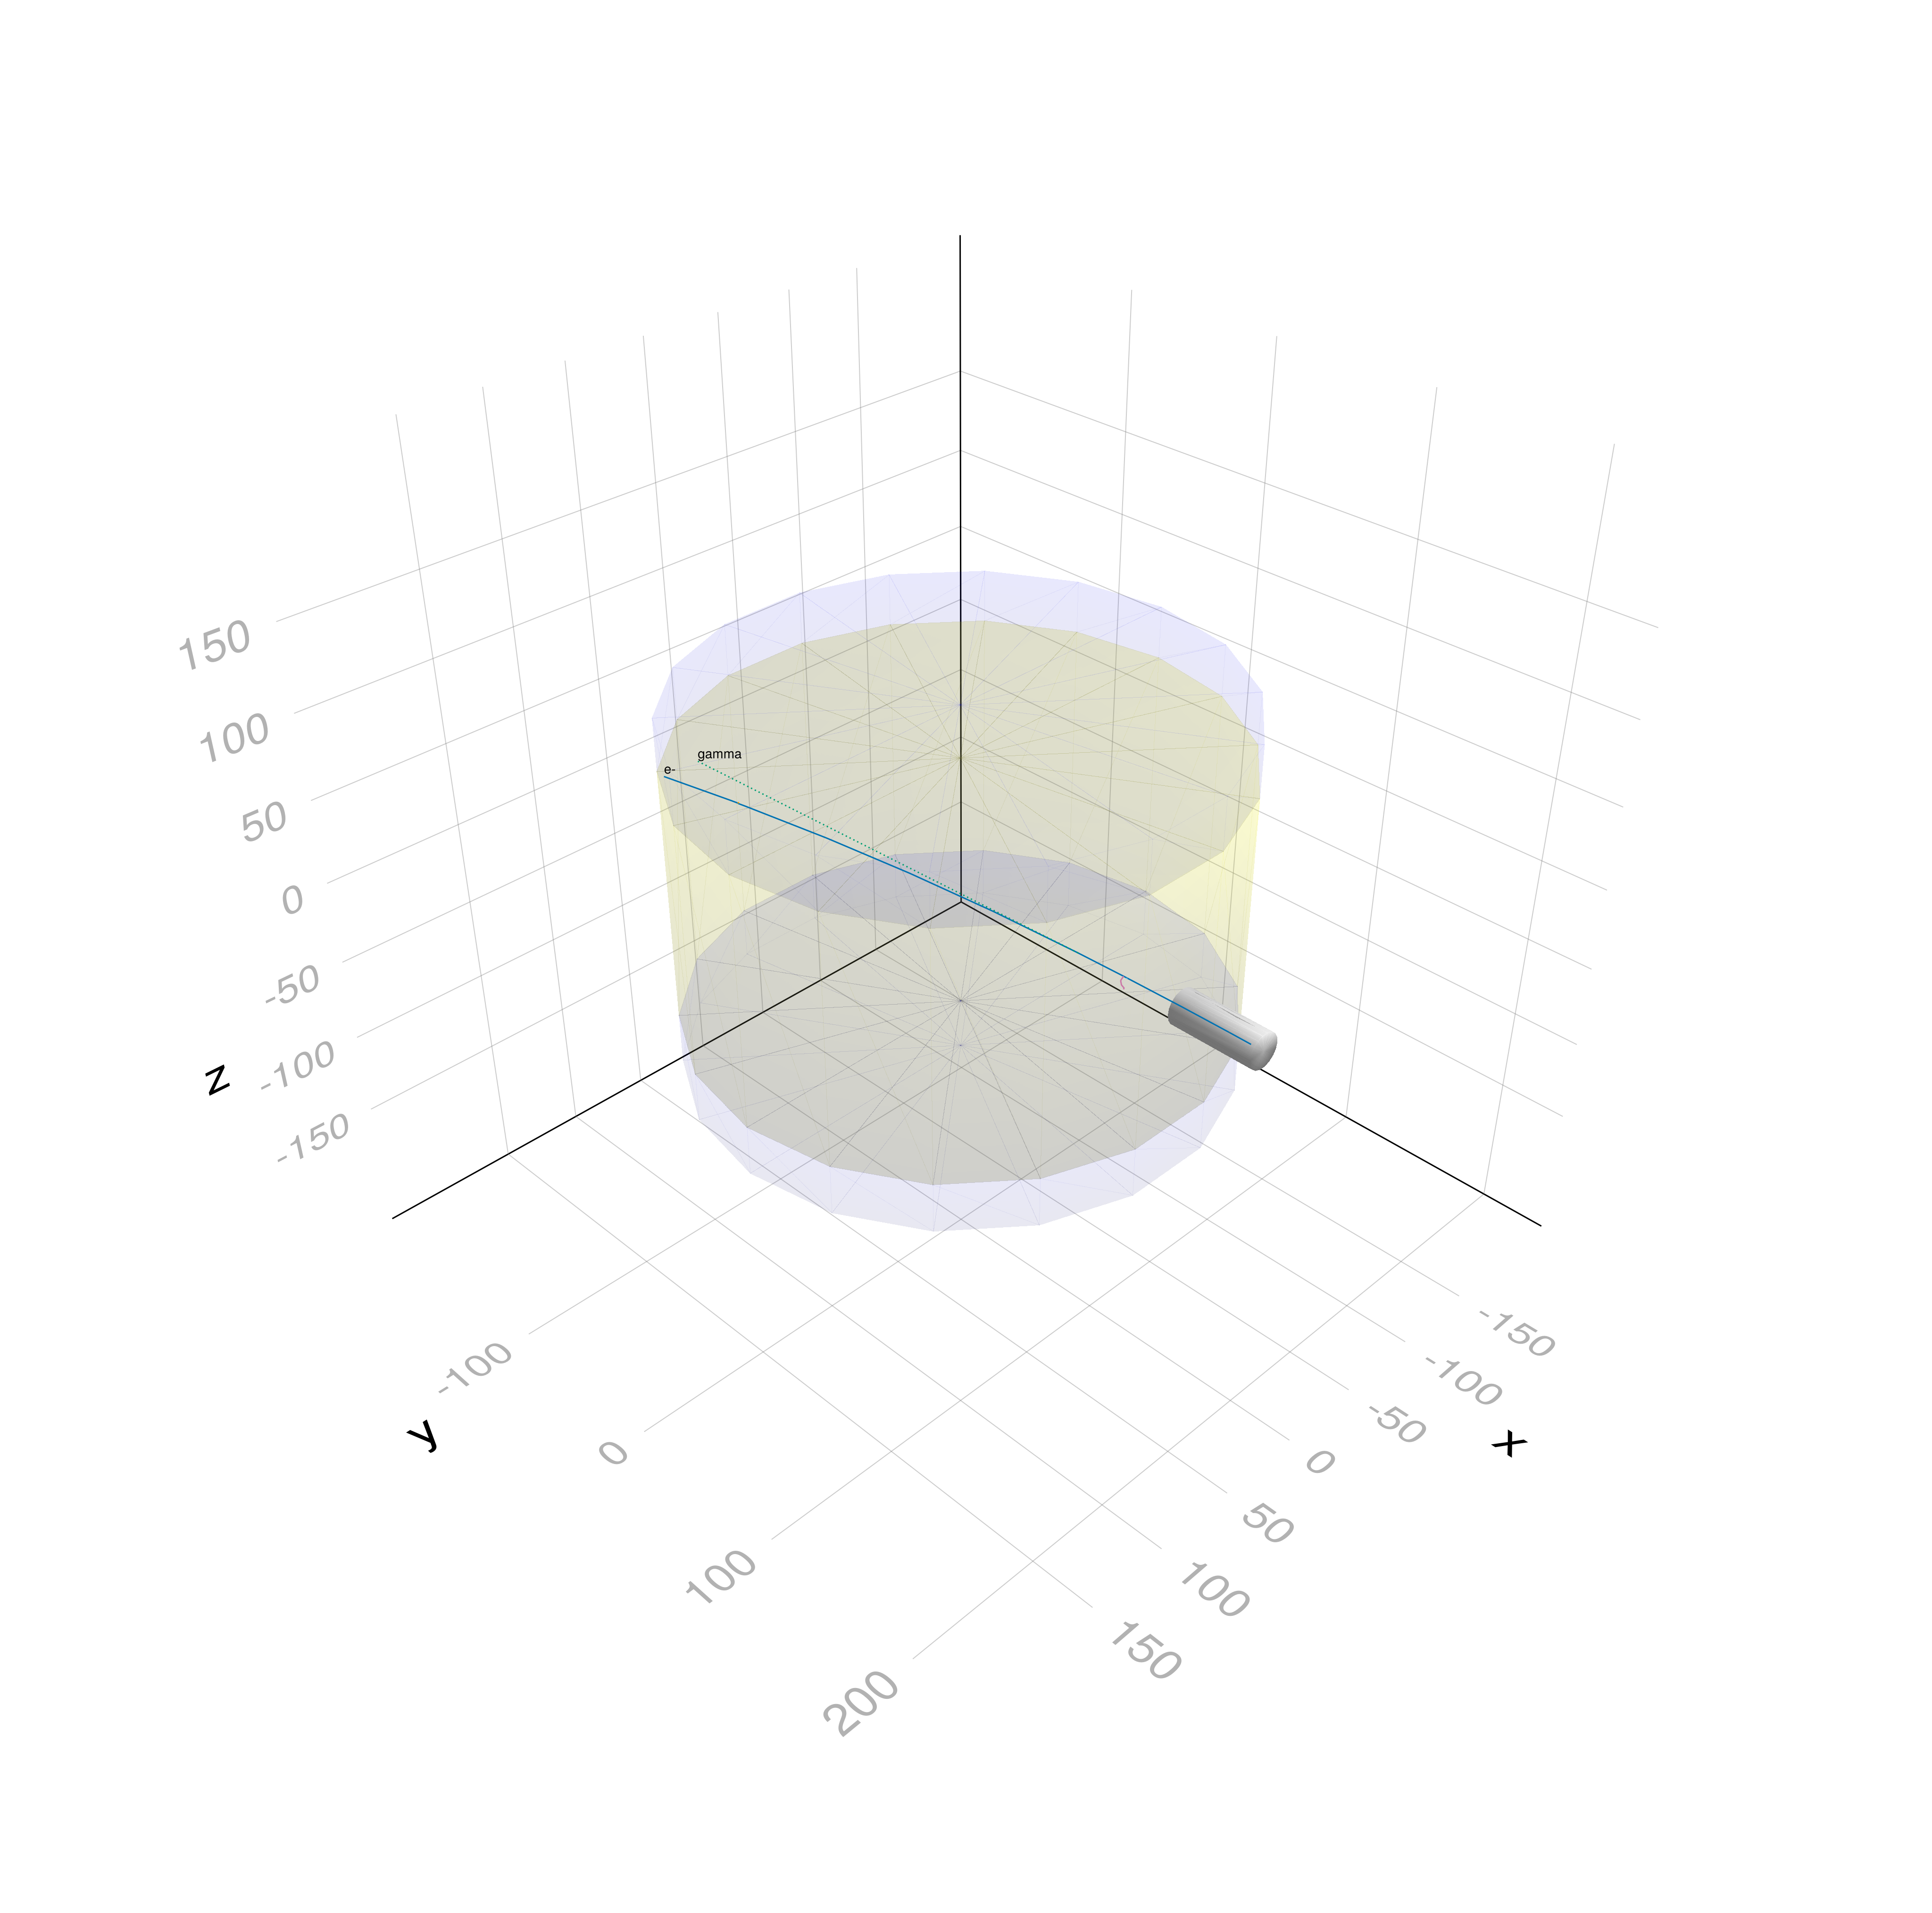

In [9]:
#---Change the energy and type of particle and draw the next event
SetParticleEnergy(particlegun, 1GeV)
SetParticleByName(particlegun, "e-")

fig = Figure(size=(2048,2028))
s = LScene(fig[1,1])

drawdetector(s, app)
nexttrigger(app); drawevent(s, app)

display("image/png", fig)